# Australian Geoscience Datacube
## Feature Summary Examples

The [Australian Geoscience Datacube](https://github.com/data-cube/agdc-v2) provides an integrated gridded data analysis environment for decades of analysis ready earth observation satellite and related data from multiple satellite and other acquisition systems.

For instructions on using the Datacube on NCI, see: http://agdc-v2.readthedocs.io/en/develop/nci_usage.html

For instructions on setting up your own instance, see: http://agdc-v2.readthedocs.io/en/develop/install.html

This notebook touches briefly on some the implimented features of the Datacube module, and is only intended to deomstrat functionality rather than be a tutorial.

In [47]:
%matplotlib inline
import datacube
import ogr
import xarray as xr
from datacube.storage import masking
import pandas
from matplotlib import pyplot as plt

If you have set up your config correctly, or are using the module on NCI, you should be able to make `Datacube` object that can connects to the configured datacube system.

In [2]:
dc = datacube.Datacube(app='dc-example')
dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://lxl554@130.56.244.227:6432/datacube)>>>

## Datacube products and measurements
The Datacube provides pandas.DataFrame representations of the available products and measurements:

In [3]:
#dc.list_products()

## Datacube Measurements
The list of measurements stored in the datacube can also be listed.

Measurements are also known as _bands_ in the imagery domain, and _data variables_ when stored in NetCDF files or when working with `xarray.Dataset` objects.

In [4]:
#dc.list_measurements()

In [5]:
#Use this if you want to specify a shapefile
#open shapefile and retrieve extents
vec_fname = '/g/data/r78/lxl554/hovmoller/Murray Mouth.shp'
vec_ds = ogr.Open(vec_fname)
layer = vec_ds.GetLayer(0)
extent = layer.GetExtent()
print "Extent: {}".format(extent)

lat_max = extent[3]
lat_min = extent[2]
lon_max = extent[1]
lon_min = extent[0]

Extent: (138.8742806106138, 138.8856287881116, -35.5589930957951, -35.55440732305348)


## Retrieve surface reflectance data


In [6]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords
#Define spatial range
'''
lat_max = -27.75
lat_min = -27.85
lon_max = 137.57756
lon_min = 137.30746
'''

#Define temporal range
start_of_epoch = '1987-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-01-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['nir','red']

#Define sensors of interest
sensor1 = 'ls8'
sensor2 = 'ls7'
sensor3 = 'ls5'


# retrieve the NBAR and PQ for the spatiotemporal range of interest


In [7]:
sensor1_nbar = dc.load(product= sensor1+'_nbar_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch), 
                   measurements = bands_of_interest,
                   group_by='solar_day')

sensor1_pq = dc.load(product= sensor1+'_pq_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch),
                   group_by='solar_day')
            

In [8]:
#This line exists to make sure that there's a 1:1 match between NBAR and PQ
sensor1_nbar = sensor1_nbar.sel(time = sensor1_pq.time)

In [9]:
sensor2_nbar = dc.load(product= sensor2+'_nbar_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch), 
                   measurements = bands_of_interest,
                   group_by='solar_day')
                   
sensor2_pq = dc.load(product= sensor2+'_pq_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch),
                   group_by='solar_day')
                   

In [11]:
sensor2_nbar = sensor2_nbar.sel(time = sensor2_pq.time)

In [12]:
sensor3_nbar = dc.load(product= sensor3+'_nbar_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch), 
                   measurements = bands_of_interest,
                   group_by='solar_day')
                   
sensor3_pq = dc.load(product= sensor3+'_pq_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch),
                   group_by='solar_day')

In [13]:
sensor3_nbar = sensor3_nbar.sel(time = sensor3_pq.time)

## Masking out no_data and cloud affected pixels
When there is no data availaible, such as on the boundaries of a scene, it is filled in with a special value.
We can use filter it out, although xarray will convert the data from `int` to `float` so that it can use `NaN` to indicate no data.

Now that bad values are no longer represented as `-9999`, the data fits on a much better colour ramp:

In [24]:
#This one works...
s1_cloud_free = masking.make_mask(sensor1_pq, 
                              cloud_acca='no_cloud', 
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
#nir = sensor1_nbar.nir.where(sensor1_nbar.nir != sensor1_nbar.nir.attrs['nodata'])
#red = sensor1_nbar.red.where(sensor1_nbar.red != sensor1_nbar.red.attrs['nodata'])
s1_good_data = s1_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor1_nbar_clean = sensor1_nbar.where(s1_good_data)

In [25]:
s2_cloud_free = masking.make_mask(sensor2_pq, 
                              cloud_acca='no_cloud', 
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
#nir = sensor1_nbar.nir.where(sensor1_nbar.nir != sensor1_nbar.nir.attrs['nodata'])
#red = sensor1_nbar.red.where(sensor1_nbar.red != sensor1_nbar.red.attrs['nodata'])
s2_good_data = s2_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor2_nbar_clean = sensor2_nbar.where(s2_good_data)

In [26]:
s3_cloud_free = masking.make_mask(sensor3_pq, 
                              cloud_acca='no_cloud', 
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
#nir = sensor1_nbar.nir.where(sensor1_nbar.nir != sensor1_nbar.nir.attrs['nodata'])
#red = sensor1_nbar.red.where(sensor1_nbar.red != sensor1_nbar.red.attrs['nodata'])
s3_good_data = s3_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor3_nbar_clean = sensor3_nbar.where(s3_good_data)

In [27]:
#Concatenate NBAR from all sensors and sort by time and likewise for PQ
nbar = xr.concat([sensor1_nbar, sensor2_nbar, sensor3_nbar], dim='time')
time_sorted = nbar.time.argsort()
nbar_sorted = nbar.isel(time=time_sorted)

nbar_clean = xr.concat([sensor1_nbar_clean, sensor2_nbar_clean, sensor3_nbar_clean], dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean_sorted = nbar_clean.isel(time=time_sorted)


The returned data is an `xarray.Dataset` object, which is a labelled n-dimensional array wrapping a `numpy` array.

We can investigate the data to see the variables (measurement bands) and dimensions that were returned:

In [37]:
def calculate_size(bytes, gb=False):
    size = bytes / 1024.0 / 1024.0
    if gb: 
        return size / 1024.0
    return size
print "Array size in Gb:{}".format(calculate_size(nbar_clean_sorted.nbytes, True))
VDIram = 12
RAMpercent = ((calculate_size(nbar_clean_sorted.nbytes, True)/VDIram)*100)
print "Selected array is " +str(RAMpercent)+ " percent of available RAM"

Array size in Gb:0.00738551467657
Selected array is 0.0615459556381 percent of available RAM


In [38]:
#to view variables
nbar_clean_sorted.data_vars

Data variables:
    nir      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    red      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...

## Some basic band maths
We can combine the `red` and `nir` (_near-infrared_) bands to calculate NDVI (_normalised difference vegetation index_).

## Pixel drill

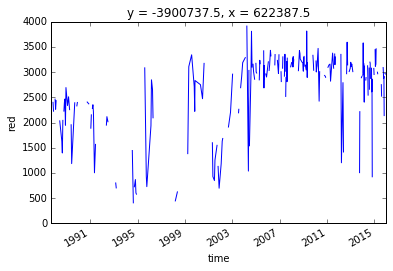

In [34]:
nbar_clean_sorted['red'].isel(x=[10], y=[10]).plot()

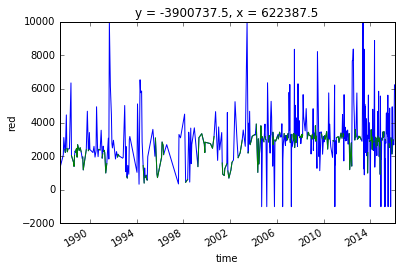

In [33]:
nbar_sorted['red'].isel(x=[10], y=[10]).plot()
nbar_clean_sorted['red'].isel(x=[10], y=[10]).plot()

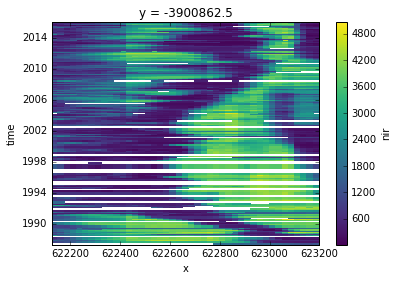

In [56]:
nbar_clean_sorted['nir'].isel(y=15).plot()


## Plotting a multi-band image

In [42]:
rgb = dc.load(product= sensor1+'_nbar_albers', 
              x=(lon_min, lon_max), y=(lat_max, lat_min), 
              time = (start_of_epoch, end_of_epoch), 
              measurements=['swir1', 'nir', 'green'], 
              group_by='solar_day', stack='color',
              #dask_chunks={'time':1, 'x': 1000, 'y': 1000} 
              ).transpose('time', 'y', 'x', 'color')
            

zip(rgb.dims, rgb.shape)

[('time', 60), ('y', 24), ('x', 43), ('color', 3)]

In [48]:
fake_saturation = 6000
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

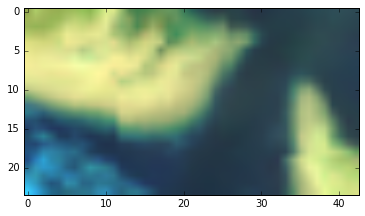

In [52]:
t= 10
fig,  figsize=(11.69,8.27)
plt.imshow(scaled.isel(time = t))



In [ ]:
#Shows syntax for multi panel plot
'''from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=2, nrows = 2, figsize=(11.69,8.27))
t = 11
axes[0,0].imshow(scaled.isel(time = t))
axes[0,0].set_title(scaled.time[t])
axes[0,1].imshow(ndvi_acca.isel(time = t), cmap = 'viridis')
axes[0,1].set_title('ACCA')
axes[1,0].imshow(ndvi_fmask.isel(time = t), cmap = 'viridis')
axes[1,0].set_title('Fmask')
axes[1,1].imshow(ndvi_saturation.isel(time = t), cmap = 'viridis')
axes[1,1].set_title('Saturated')'''
#tight_layout()

In [ ]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=2, nrows = 2, figsize=(11.69,8.27))
t = 3
axes[0,0].imshow(scaled.isel(time = t))
axes[0,0].set_title(scaled.time[t])
axes[0,1].imshow(acca_good_data.sum('time')/pq_contig.sum('time').astype(float))
axes[0,1].set_title('ACCA')
axes[1,0].imshow(fmask_good_data.sum('time')/pq_contig.sum('time').astype(float))
axes[1,0].set_title('Fmask')
axes[1,1].imshow(saturation_good_data.sum('time')/pq_contig.sum('time').astype(float))
axes[1,1].set_title('Saturated')
#tight_layout()'''

In [ ]:
#fig,  figsize=(11.69,8.27)


saturation_good_data.sum('time').plot()

In [ ]:
acca_good_data.sum('time').plot()

In [ ]:
plt.imshow(ndvi_acca.isel(time = t), cmap = 'viridis')

In [ ]:
plt.imshow(ndvi_fmask.isel(time = t), cmap = 'viridis')

In [ ]:
plt.imshow(ndvi_saturation.isel(time = t), cmap = 'viridis')